In [10]:
import pandas as pd
import numpy as np
import librosa
from datasets import Dataset, Audio
from datasets import load_dataset, DatasetDict, load_from_disk

import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

import evaluate

from transformers import WhisperTokenizer
from transformers import Seq2SeqTrainer
from transformers import WhisperFeatureExtractor
from transformers import WhisperProcessor
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments
from transformers import (
    AutoConfig,
    AutoFeatureExtractor,
    AutoModelForSpeechSeq2Seq,
    AutoProcessor,
    AutoTokenizer,
    HfArgumentParser,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)

In [11]:
config = {
    'language':'Bengali',
    'base_model' : "anuragshas/whisper-large-v2-bn",
    'sr':16000,
    'samples':500000,
    'test_size':4000,
    'load_ds':False
}

In [12]:
df = pd.read_csv("../data/train.csv")

In [13]:
df_qa = pd.read_csv('../data/NISQA_wavfiles.csv')
df_qa.rename(columns={'deg':'id'},inplace=True)
df_qa['id'] = df_qa['id'].apply(lambda x:x.split('.')[0])
df_qa.sort_values('mos_pred',ascending=True,inplace=True)

In [14]:
df = df.merge(df_qa[['id','mos_pred']], how='left')

In [16]:
df = df.loc[df['mos_pred'] > 2.].reset_index(drop=True)

In [17]:
all_single_sentences = list(set(df['sentence'].tolist()))
len(all_single_sentences)

338675

In [18]:
sentence_dict = {}
unique_id = 0
result = {}

for idx, sentence in enumerate(all_single_sentences):
    if sentence not in sentence_dict:
        sentence_dict[sentence] = unique_id
        result[unique_id] = [idx]
        unique_id += 1
    else:
        result[sentence_dict[sentence]].append(idx)

In [34]:
df['sentence_ids'] = df['sentence'].apply(lambda x: sentence_dict[x])

<AxesSubplot:>

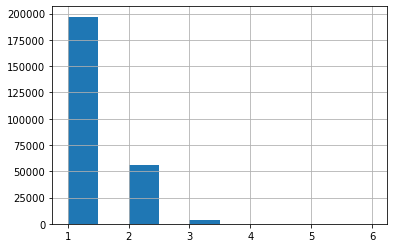

In [35]:
df['sentence_ids'].value_counts().hist()

In [36]:
df['sentence_ids'].value_counts().mean()

1.2447823319705897

In [37]:
import random
random.seed(42)
val_ids = random.sample(list(df['sentence_ids'].unique()), 3000)

In [38]:
df['split_own'] = 'train'

In [39]:
df.loc[df['sentence_ids'].isin(val_ids), 'split_own'] = 'val'

In [40]:
crosscheck_list = list(set(df.loc[df['split_own'] == 'val']['sentence']))

In [41]:
df.loc[df['sentence'].isin(crosscheck_list)]['split_own'].value_counts()

val    3781
Name: split_own, dtype: int64

In [42]:
test = df.loc[df['split_own'] == 'val']
train = df.loc[df['split_own'] == 'train']

In [43]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
print(len(train))
print(len(test))

315009
3781


In [44]:
len(df)

318790

In [45]:
train['path'] = train['id'] + ".mp3"
test['path'] = test['id'] + ".mp3"

In [46]:
test.to_csv("../data/val_v20.csv",index=False)
train.to_csv("../data/train_v20.csv",index=False)